# TP 14: Predicting dynamics with Neural-ODE


**The goal of this pratical is use machine learning models to predict the evolution of dynamical systems driven by physical laws, *e.g.* ordinary Differential Equations (ODE).**

Let us considers a physcial system in Newtonian mechanichs composed of a **damped pendulum**, with length $l$ and mass $m$, and $\theta$ being the angle with respect to the vertical direction:
<img src="./pendulum.png" width="200">

**Let us denote $\dot{\theta_t}:=\frac{d\theta}{dt}$ and $\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ as the first and second temporal derivatives of $\theta$.** The dynamics of the pendulum is driven bt the following ODE on $\theta$:


\begin{equation*} \ddot{\theta_t} + \omega_0^2~ sin\left(\theta_t\right) + \alpha \dot{\theta}_t = 0
\end{equation*}

where $\omega_0 = \sqrt{\frac{g}{l}}$ ($g$ is the gravitational constant), and $\alpha = \frac{k}{ml^2}$ is the friction coefficient.

In the general case, the ODE in Eq (\ref{eq1}) does not have a closed-form solution. Let us denote as $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ the 2d state vector of the pendulum. 



 **<u>Question 1:</u> show that $\dot{\mathbf{Y}_t}=f\left({\mathbf{Y}_t}\right)$, *i.e* that the evolution of $\mathbf{Y}$ follows a first-order ODE. Give the expression of f.** 

From a given initial condition $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$, we can estimate the state vector $\mathbf{Y}_t$ at any time $t$: 

\begin{equation*}
\mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt = \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
\end{equation*}

where $f\left( \mathbf{Y}_t \right)$ only depends on the current state $\mathbf{Y}_t$ at time $t$. The integral in Eq (\ref{eq2}) can be approximated with numerical schemes. The Euler method is simplest one (see figure below): starting from $\mathbf{Y}_0$, we have $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} + f\left(\mathbf{Y}_t\right)$ $\forall t>1$. The has been extensive studies for developping improved numerical solvers in the last centuries, e.g. different orders of Runge-Kutta solvers.
<img src="./Euler.png" width="200">

## Part I. Generating damped pendulum simulations
First, lets do some import

In [1]:
import math, shelve
import os

from collections import OrderedDict

import torch
import numpy as np
from scipy.integrate import solve_ivp

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from torchdiffeq import odeint_adjoint, odeint

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]


In [2]:
plt.style.use("ggplot")

In [2]:
import datetime

In [21]:
from torch.utils.tensorboard import SummaryWriter

### I.a) DampledPendulum

**We will write a DampledPendulum Dataset, which simulates different pendulum trajectories from differents initial conditions. Fill the code in the code in the following DampledPendulum class. We use the following setting:** $\omega_0^2= \frac{\Pi}{6}$, $\alpha= 0.2$, time hoziron : 10, with $dt=0.5$. 

You have to fill the __init__, __len__ and  __getitem__ functions. For __getitem__, the goal is to simulate a given trajectory from an initial condition: 
- The function _get_initial_condition is provided
- To perform the simulation in __getitem__, you need to: 
    - Call the _get_initial_condition
    - Call the solver: we will use the solve_ivp method from from scipy.integrate, using the 'DOP853' method (Explicit Runge-Kutta method of order 8). 
- Since the simulation is computationnaly demanding, it can be a good idea to store the states in the class

In [4]:
class DampledPendulum(Dataset):
    def __init__(self, time_horizon, n_points, batch_len=10):
    
        super().__init__()
        
        self.omega0_square = np.pi / 6 # FILL WITH YOUR CODE
        self.alpha = 0.2 # FILL WITH YOUR CODE
        self.len = n_points
        self.batch_len = batch_len
        self.time_horizon = time_horizon # FILL WITH YOUR CODE
        self.t_eval = torch.linspace(0, time_horizon, n_points)
        self.y0 = torch.tensor([2., 0.])
        self.data = odeint(
            lambda t, y: torch.tensor([y[1], -self.omega0_square * torch.sin(y[0]) - self.alpha * y[1]]),
            y0=self.y0,
            t=self.t_eval
        )
        
    def __getitem__(self, index):
        if index > self.len - self.batch_len:
            return self.data[index:], self.t_eval[:(self.len-index)]
        
        return self.data[index:index+self.batch_len], self.t_eval[:self.batch_len]

    def __len__(self):
        # FILL WITH YOUR CODE
        return self.len

In [5]:
class DampledPendulumTest(Dataset):
    def __init__(self, num_seq, time_horizon, n_points):
    
        super().__init__()
        
        self.omega0_square = np.pi / 6 # FILL WITH YOUR CODE
        self.alpha = 0.2 # FILL WITH YOUR CODE
        self.len = num_seq
        self.time_horizon = time_horizon # FILL WITH YOUR CODE
        self.t_eval = torch.linspace(0, time_horizon, n_points)
        self.data = {}
        
    def _get_initial_condition(self, seed):
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0 ** 2).sum()) * r
        if np.abs(y0[1]) > 0.5:
            y0[1] = 0
        
        return y0
        
    def __getitem__(self, index):
        if self.data.get(str(index)) is None:
            # GET INITIAL CONDITIONS 
            y0 = self._get_initial_condition(index)
            # PERFORM SIMULATION (i.e. NUMERICAL INTEGRATION) - FILL WITH YOUR CODE
            data = odeint(
                lambda t, y: torch.tensor([y[1], -self.omega0_square * torch.sin(y[0]) - self.alpha * y[1]]),
                y0=torch.from_numpy(y0),
                t=self.t_eval)

            self.data[str(index)] = {"states": data, "t": self.t_eval}
        
        return self.data.get(str(index))

    def __len__(self):
        # FILL WITH YOUR CODE
        return self.len

In [10]:
def pad_collate_fn(samples):
    truncated_batch = [
        sample[0].unsqueeze(0) for sample in samples
        if sample[0].size(0) == 10
    ]
    
    t = [
        sample[1] for sample in samples
        if sample[0].size(0) == 10
    ]
    return torch.cat(truncated_batch), t[0]

### I.b) Train/test data generation
**We can now define train and test dataloader** (use 25 train/test sequences with a batch size of 25).
**Plot the resulting trajectories ($\theta$ and optionally $\dot{\theta}$).**

#### Training data

Text(0.5, 1.0, 'Angular velocity')

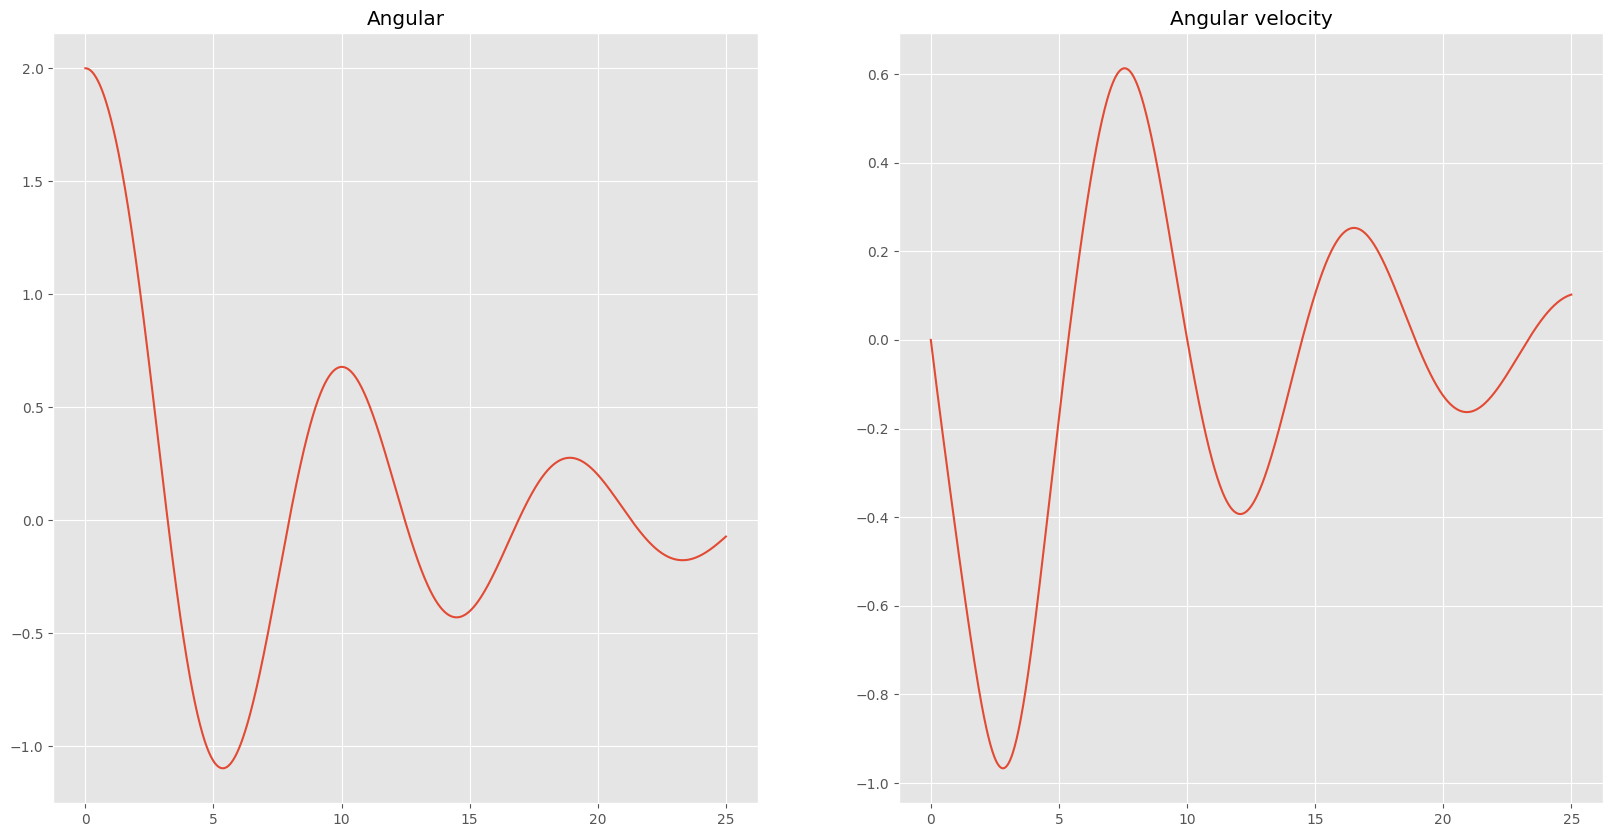

In [12]:
dataset = DampledPendulum(time_horizon=25, n_points=1000)

fig, axes = plt.subplots(1, 2)
axes[0].plot(dataset.t_eval, dataset.data[:, 0])
axes[1].plot(dataset.t_eval, dataset.data[:, 1])
axes[0].set_title("Angular")
axes[1].set_title("Angular velocity")


#### Test data

In [13]:
test_dataset = DampledPendulumTest(num_seq=50, time_horizon=25, n_points=1000)

Text(0, 0.5, 'angular velocity')

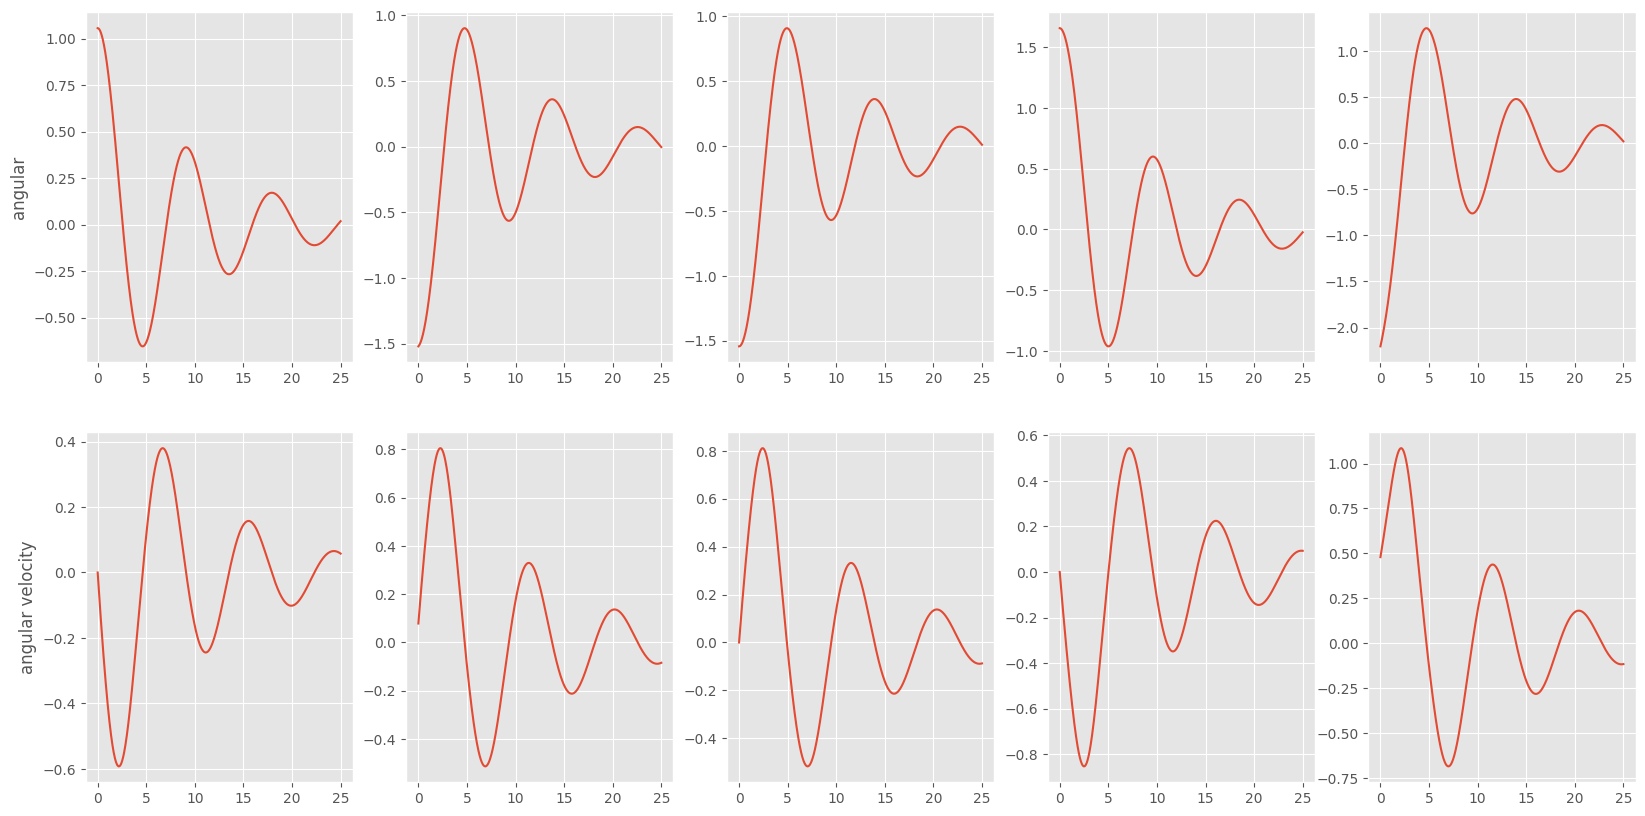

In [14]:
fig, axes = plt.subplots(2, 5)
for i in range(5):
    states, t = test_dataset[i]["states"], test_dataset[i]["t"]
    axes[0, i].plot(t, states[:, 0])
    axes[1, i].plot(t, states[:, 1])

axes[0, 0].set_ylabel("angular")
axes[1, 0].set_ylabel("angular velocity")

## 2) Predicting trajectories with Neural-ODE

**The goal is to use the Neural-ODE method [1] to predict the future trajectory from an initial condition.** As mentionned before, the idea is to define a parametric model to predict the state's derivative from the current state value.

**Let's fill the DerivativeEstimator class to predict the the state's derivative.** We will use a simple MLP (2 hiddenn layers + ReLU) for prediction since the state is a 2D vector. 


In [15]:
class DerivativeEstimator(nn.Module):
    def __init__(self, n_state, n_hidden):
        super().__init__()
        # FILL WITH YOUR CODE
        self.model = nn.Sequential(
            nn.Linear(n_state, n_hidden, bias=False),
            nn.ReLU(),
            nn.Linear(n_hidden, n_state, bias=False)
        )

    def forward(self, t, state):
        # FILL WITH YOUR CODE
        return self.model(state)

**The forecasterwill perform the prediction from a initial state $y_0$**. To perform the numerical integration, we use the 'odeint' method from torchdiffeq. We will use the generic 'rk4' solver to perform numerical integration. **Fill the following  Forecaster class with:** 
- A constructor creating a reference to an DerivativeEstimator instance 
- the forward method calls the odeint method to perform integration from an initial $y_0$ state. **N.B.**: the output dimensions after calling odeint will be T x batch_size x n_c, swap them to fit the requested Pytorch standard (batch_size x n_c X T)

In [16]:
class Forecaster(nn.Module):
    def __init__(self, n_state , n_hidden, method='rk4'):
        super().__init__()
        self.func = DerivativeEstimator(n_state, n_hidden)
        
    def forward(self, y0, t):
        # CALL TO ODEINT + DIM SWAP
        return odeint(self.func, y0, t, method="rk4")

### Write the training loop!
For each batch: 
- Get the first state of each training trajectory
- Perform prediction of the forecaster for each time step of the horizon
- We will use a simple MSE loss between the ground truth and predicted trajectories.
- Use an Adam optimizer (default paramters)
- Plot the train / test trajectories

In [17]:
import wandb

In [18]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [19]:
run = wandb.init(
    project="NeuralODE",
    name="Damped-Pendulum"
)

In [21]:
n_state = 2
n_hidden = 200
n_epochs = 1001
dataset = DampledPendulum(time_horizon=25, n_points=1000)
train_loader = DataLoader(dataset, collate_fn=pad_collate_fn, batch_size=32, drop_last=True)
odenet = Forecaster(n_state, n_hidden)
optim = torch.optim.Adam(params=odenet.parameters())
loss_f = nn.L1Loss()

it = 0

for e in range(n_epochs):
    for iteration, batch in enumerate(train_loader): 
        states, t = batch[0].transpose(1, 2), batch[1]
        y0 = states[:, :, 0]
        y_pred = odenet(y0, t)
        y_pred = y_pred.permute(1, 2, 0)
        loss = loss_f(y_pred, states)
        if it >= 20:
            run.log({"train/loss": loss}, step=it)
        loss.backward()
        optim.step()
        optim.zero_grad()

        it += 1




In [22]:
odenet = odenet.float()

Text(0, 0.5, 'angular velocity')

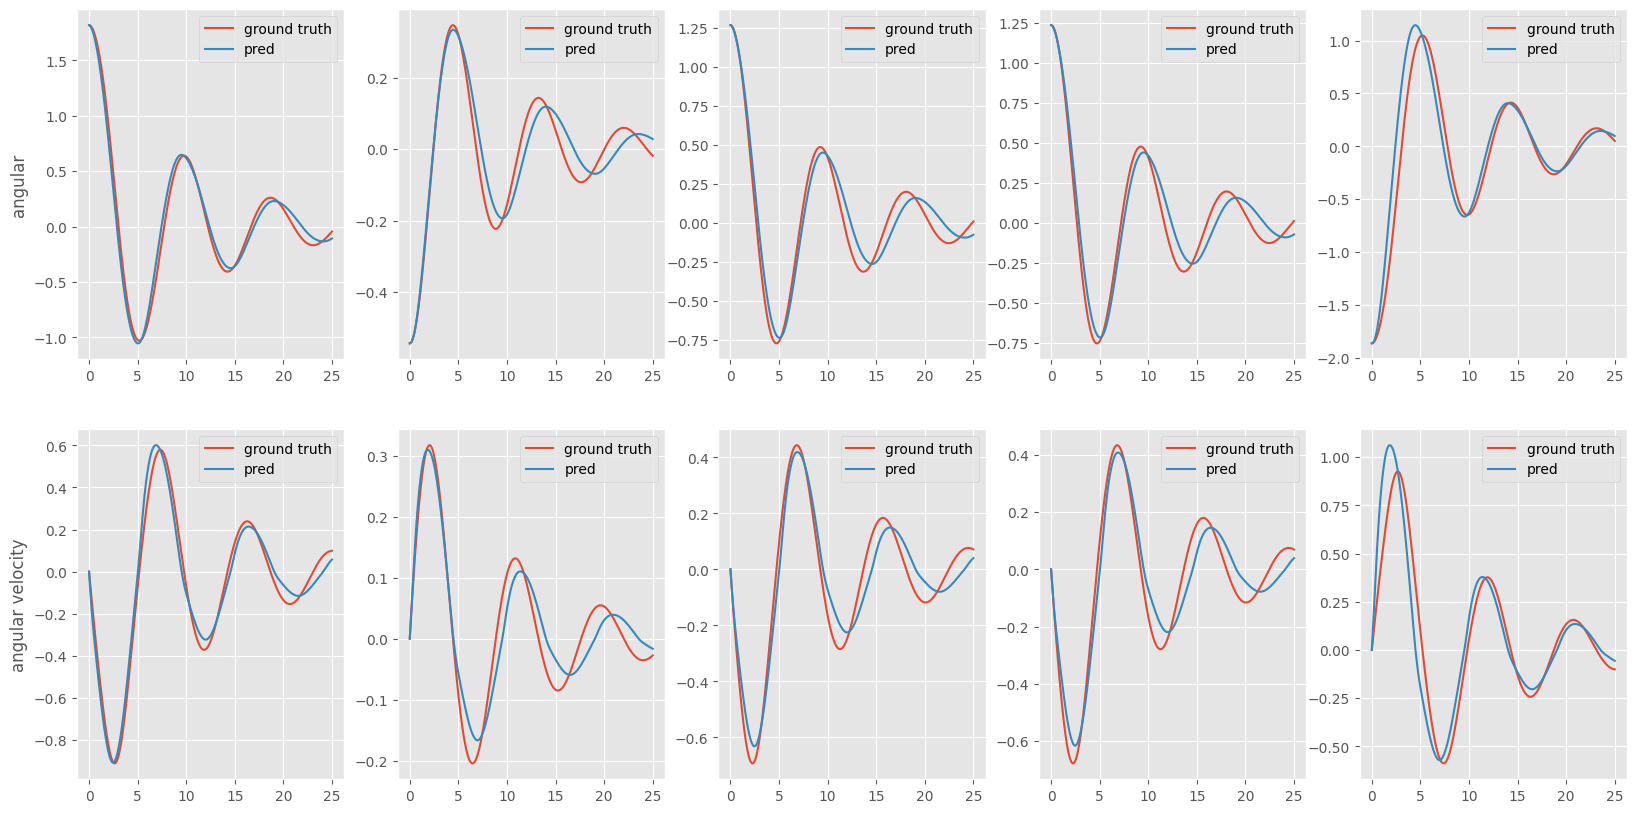

In [23]:
fig, axes = plt.subplots(2, 5)
test_dataset = DampledPendulumTest(num_seq=50, time_horizon=25, n_points=1000)
for i in range(5):
    x = test_dataset[i]
    states, t = x["states"], x["t"]
    theta, velocity = states[:, 0], states[:, 1]
    axes[0, i].plot(t, theta, label="ground truth")
    axes[1, i].plot(t, velocity, label="ground truth")

    pred = odenet(states[0, :].float(), t.float()).detach().numpy()
    theta_pred = pred[:, 0]
    velocity_pred = pred[:, 1]
    axes[0, i].plot(t, theta_pred, label="pred")
    axes[1, i].plot(t, velocity_pred, label="pred")

    axes[0, i].legend()
    axes[1, i].legend()
    
axes[0, 0].set_ylabel("angular")
axes[1, 0].set_ylabel("angular velocity")
